In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any

In [2]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    
def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

In [3]:
BACKBONE_LOGS = glob("../logs/ex_backbone/*/*.json")
BACKBONE_LOGS[:5], len(BACKBONE_LOGS)

(['../logs/ex_backbone\\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\\report.2025.09.10.201009.json',
  '../logs/ex_backbone\\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\\report.2025.09.10.201141.json',
  '../logs/ex_backbone\\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\\report.2025.09.10.201252.json',
  '../logs/ex_backbone\\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\\report.2025.09.10.201316.json',
  '../logs/ex_backbone\\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\\report.2025.09.10.201445.json'],
 311)

# Thí nghiệm backbone

In [4]:
demo = load_json(BACKBONE_LOGS[0])
demo.keys()

dict_keys(['enviroment', 'setup', 'result', 'step_by_step'])

In [5]:
demo["result"]

{'winner': 'player_a', 'score': [23, 21], 'final_round': 12}

In [6]:
demo["setup"]

{'player_a': {'endpoint': 'deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free',
  'mem_size': 10,
  'persona': 'BALANCE',
  'temp': 0.7,
  'top_p': 1.0,
  'top_k': 40.0,
  'max_token': 256},
 'player_b': {'endpoint': 'random_agent',
  'mem_size': None,
  'persona': None,
  'temp': None,
  'top_p': None,
  'top_k': None,
  'max_token': None}}

In [7]:
def get_model_name(endpoint):
    d = {
        "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8": "Llama-4-Maverick-17B-128E",
        "deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free": "DeepSeek-R1-Distill-Llama-70B",
        "gemini-2.0-flash": "Gemini-2.0-flash",
        "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free": "Llama-3.3-70B-Instruct",
        "exaone-3-5-32b-instruct": "ExaOne-3.5-32B-Instruct",
        "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo": "Llama-3.1-8B-Instruct",
        "gemini-2.0-flash-lite": "Gemini-2.0-flash-lite",
    }
    return d.get(endpoint, endpoint)
    

In [8]:
def win_rate(paths):
    winners = []
    for path in paths:
        try:
            
            log = load_json(path)
            # if log["result"]["final_round"] > 7:
            #     continue
            endpoint = log["setup"][log["result"]["winner"]]["endpoint"]
            winners.append(get_model_name( endpoint ))
        except:
            pass
    
    return dict(Counter(winners))

def calc_ratio(results: dict):
    total = sum(results.values())
    ratios = {}

    for agent, count in results.items():
        ratios[agent] = round( count * 100 / total, 2) if total > 0 else 0.0

    return ratios


win_rate_report = {
    "DeepSeek-R1-Distill-Llama-70B": calc_ratio(win_rate(glob("../logs/ex_backbone/deepseek-aiDeepSeek-R1-Distill-Llama-70B-free/*"))),
    "Llama-3.3-70B-Instruct": calc_ratio(win_rate(glob("../logs/ex_backbone/meta-llamaLlama-3.3-70B-Instruct-Turbo-Free/*"))),
    "Gemini-2.0-flash-lite": calc_ratio(win_rate(glob("../logs/ex_backbone/gemini-2.0-flash-lite/*"))),
    "ExaOne-3.5-32B-Instruct": calc_ratio(win_rate(glob("../logs/ex_backbone/lgaiexaone-3-5-32b-instruct/*"))),
    "Llama-3.1-8B-Instruct": calc_ratio(win_rate(glob("../logs/ex_backbone/meta-llamaLlama-3.3-70B-Instruct-Turbo-Free/*"))),
    "Llama-4-Maverick-17B-128E": calc_ratio(win_rate(glob("../logs/ex_backbone/llama4/*"))),
}

win_rate_report

{'DeepSeek-R1-Distill-Llama-70B': {'DeepSeek-R1-Distill-Llama-70B': 66.67,
  'random_agent': 33.33},
 'Llama-3.3-70B-Instruct': {'Llama-3.3-70B-Instruct': 42.0,
  'random_agent': 58.0},
 'Gemini-2.0-flash-lite': {'Gemini-2.0-flash-lite': 54.55,
  'random_agent': 45.45},
 'ExaOne-3.5-32B-Instruct': {'random_agent': 56.52,
  'lgai/exaone-3-5-32b-instruct': 43.48},
 'Llama-3.1-8B-Instruct': {'Llama-3.3-70B-Instruct': 42.0,
  'random_agent': 58.0},
 'Llama-4-Maverick-17B-128E': {'random_agent': 54.29,
  'Llama-4-Maverick-17B-128E': 45.71}}

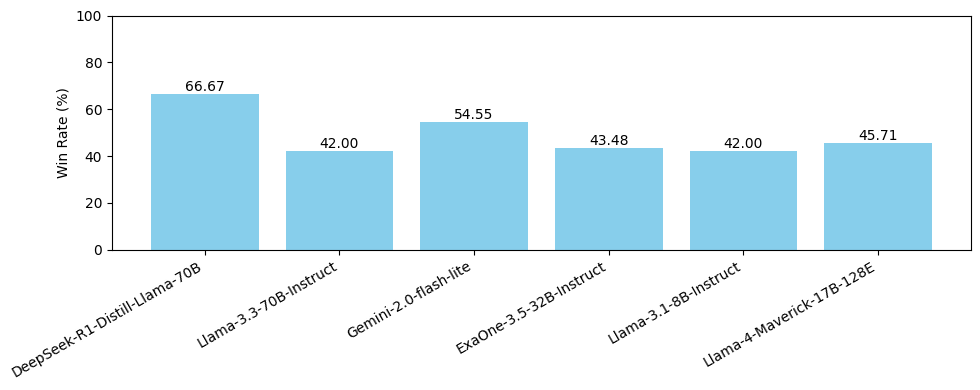

In [9]:
def plot_win_rate_report(data):
    plt.figure(figsize=(10, 4))

    for idx, (agent, results) in enumerate(data.items()):
        # Lọc bỏ "random_agent"
        filtered = {k: v for k, v in results.items() if k != "random_agent"}
        for i, (model, val) in enumerate(filtered.items()):
            plt.bar(idx, val, color="skyblue")
            plt.text(idx, val + 0.01, f"{val:.2f}", ha="center", va="bottom", fontsize=10)

    # Gán nhãn
    plt.xticks(range(len(data)), data.keys(), rotation=30, ha="right")
    plt.ylabel("Win Rate (%)")
    plt.ylim(0, 100)
    plt.tight_layout()

    plt.show()
    
plot_win_rate_report(win_rate_report)

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

def reasoning_time(paths):
    """
    Lấy reasoning time của agent chính (bỏ random_agent).
    Trả về list các list, mỗi list là reasoning time theo round cho 1 file.
    """
    all_times = []

    for path in paths:
        try:
            log = load_json(path)
            player_a = log["setup"]["player_a"]["endpoint"]
            player_b = log["setup"]["player_b"]["endpoint"]

            # xác định agent chính (bỏ random_agent)
            main_agent = player_a if "random_agent" not in player_a else player_b

            times = []
            for step in log.get("step_by_step", []):
                # Bỏ qua step nếu reasoning thuộc random_agent
                if step.get("reasoning_times") and step.get("reason"):
                    # "reason" là string mô tả suy nghĩ, chỉ có ở agent chính
                    if "random" not in step["reason"].lower():
                        times.append(step["reasoning_times"])
            if times:
                all_times.append(times)
        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    return all_times


reasoning_curve_report = {
    "DeepSeek-R1-Distill-Llama-70B": reasoning_time(glob("../logs/ex_backbone/deepseek-aiDeepSeek-R1-Distill-Llama-70B-free/*")),
    "Llama-4-Maverick-17B-128E": reasoning_time(glob("../logs/ex_backbone/llama4/*")),
    "Gemini-2.0-flash-lite": reasoning_time(glob("../logs/ex_backbone/gemini-2.0-flash-lite/*")),
    "ExaOne-3.5-32B-Instruct": reasoning_time(glob("../logs/ex_backbone/lgaiexaone-3-5-32b-instruct/*")),
    "Llama-3.1-8B-Instruct": reasoning_time(glob("../logs/ex_backbone/meta-llamaLlama-3.3-70B-Instruct-Turbo-Free/*")),
}

reasoning_curve_report

Skip ../logs/ex_backbone/llama4\report.2025.09.18.210633.json vì lỗi: 'endpoint'


{'DeepSeek-R1-Distill-Llama-70B': [[5.206918,
   10.545739,
   6.670099,
   6.776794,
   6.890774,
   6.945827,
   9.039979,
   7.964166,
   8.203762,
   5.305471,
   11.360454,
   6.811921],
  [6.868534,
   7.309905,
   7.321641,
   7.82271,
   13.140039,
   8.149785,
   7.54164,
   6.960461,
   5.082221],
  [7.645731, 7.189658, 9.281948],
  [5.970022, 11.86797, 26.945073, 10.742882, 9.988025, 15.17289, 7.575655],
  [6.199801, 7.351475, 9.663896, 11.58183, 10.048216, 10.262021],
  [9.658338,
   7.58767,
   8.896045,
   9.439828,
   8.301665,
   10.497468,
   16.690948,
   17.297808,
   10.633127,
   10.962549,
   12.903631,
   14.585484],
  [10.098357, 11.664536, 16.155858, 14.788286],
  [9.804097, 14.951426, 16.396546, 7.719339],
  [12.509568,
   10.705639,
   12.510641,
   11.864555,
   14.278702,
   16.521254,
   19.587699,
   12.689703,
   11.996738,
   9.364585,
   10.628689,
   11.793117],
  [7.082099,
   5.69392,
   9.933489,
   10.933462,
   9.074621,
   10.257356,
   12.31060

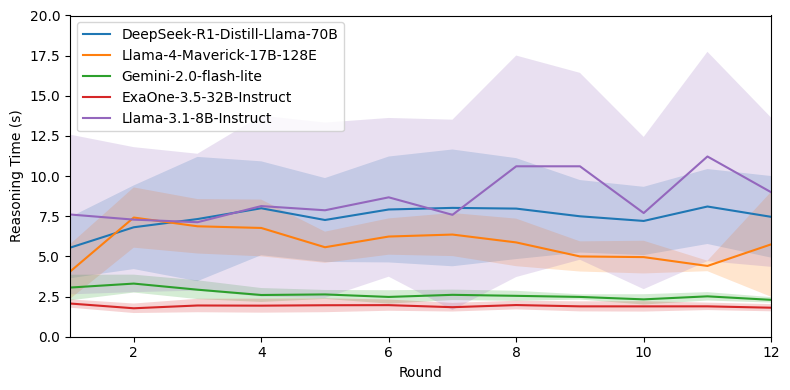

In [11]:

import numpy as np
import matplotlib.pyplot as plt

def plot_reasoning_multi_agents(reasoning_curve_report, max_round=12):
    """
    Vẽ đường trung bình reasoning time cho nhiều agent chung trên 1 plot
    Tính trung bình đến max_round (padding nếu game ngắn hơn)
    """
    plt.figure(figsize=(8, 4))

    for agent_name, all_times in reasoning_curve_report.items():
        if not all_times:
            continue

        # padding các game thành cùng độ dài max_round
        padded = []
        for seq in all_times:
            seq = seq[:max_round]  # cắt bớt nếu dài hơn
            if len(seq) < max_round:
                seq = seq + [np.nan] * (max_round - len(seq))  # pad NaN
            padded.append(seq)

        arr = np.array(padded, dtype=float)

        mean_vals = np.nanmean(arr, axis=0)
        std_vals = np.nanstd(arr, axis=0)
        x = np.arange(1, max_round+1)

        # Vẽ đường trung bình
        plt.plot(x, mean_vals, label=agent_name)

        # Vẽ shaded std
        plt.fill_between(x, mean_vals-std_vals, mean_vals+std_vals, alpha=0.2)

    plt.ylim(0, 20)
    plt.xlim(1, max_round)
    plt.xlabel("Round")
    plt.ylabel("Reasoning Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
plot_reasoning_multi_agents(reasoning_curve_report)

Skip ../logs/ex_backbone\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\report.2025.09.10.201540.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\deepseek-aiDeepSeek-R1-Distill-Llama-70B-free\report.2025.09.15.223930.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\gemini-2.0-flash\report.2025.09.16.011840.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\gemini-2.0-flash\report.2025.09.16.012915.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\gemini-2.0-flash-lite\report.2025.09.10.193723.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\lgaiexaone-3-5-32b-instruct\report.2025.09.15.222157.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\lgaiexaone-3-5-32b-instruct\report.2025.09.15.222243.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\lgaiexaone-3-5-32b-instruct\report.2025.09.15.222322.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\lgaiexaone-3-5-32b-instruct\report.2025.09.15.222608.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\llama4\report.2025.09.18.204849.json vì lỗi: 'draw'
Skip ../logs/ex_backbone\llama4\r

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14940\5071073.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


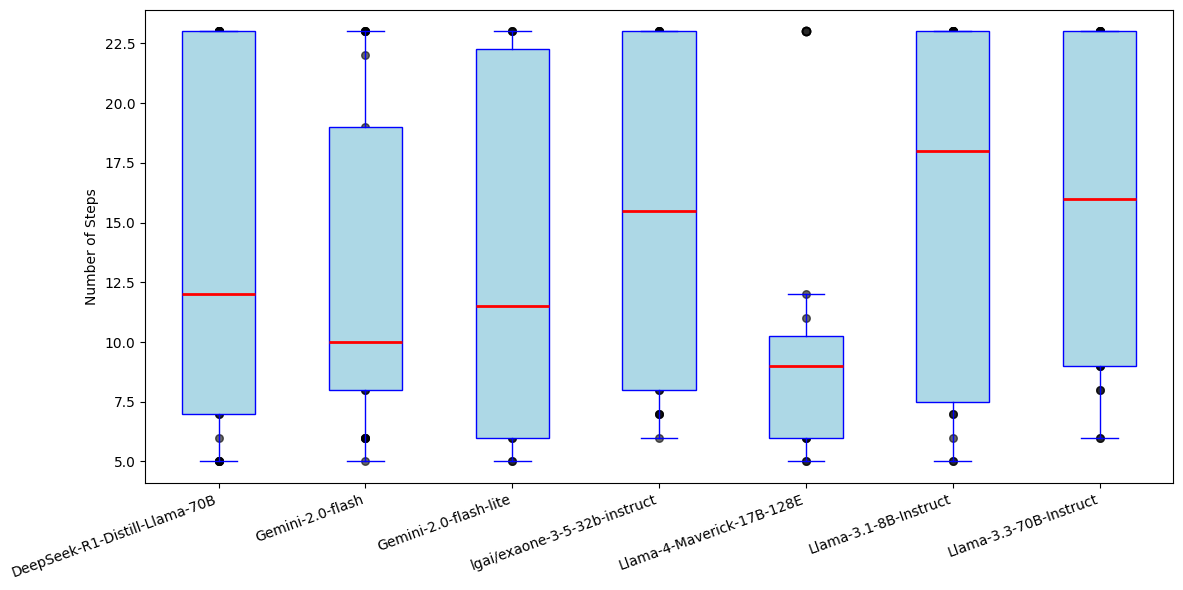

In [12]:
import matplotlib.pyplot as plt

def collect_win_steps(paths, group_by="endpoint"):
    """
    Trả về dict {agent_name: [số bước khi agent thắng]}
    """
    win_steps = defaultdict(list)

    for path in paths:
        try:
            log = load_json(path)
            winner = log["result"]["winner"]
            endpoint = get_model_name(log["setup"][winner][group_by])

            # bỏ random_agent
            if "random_agent" in endpoint:
                continue

            steps = len(log.get("step_by_step", []))
            win_steps[endpoint].append(steps)

        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    return win_steps

def plot_win_steps_box_scatter(win_steps):
    """
    Vẽ box plot + scatter overlay cho số bước thắng của từng agent
    """
    agents = list(win_steps.keys())
    data = [win_steps[agent] for agent in agents]

    plt.figure(figsize=(12, 6))

    # Vẽ boxplot
    box = plt.boxplot(
        data,
        labels=agents,
        patch_artist=True,
        boxprops=dict(facecolor="lightblue", color="blue"),
        medianprops=dict(color="red", linewidth=2),
        whiskerprops=dict(color="blue"),
        capprops=dict(color="blue")
    )

    # Overlay scatter cho từng agent
    for i, steps in enumerate(data, start=1):
        x = [i] * len(steps)
        plt.scatter(x, steps, alpha=0.6, color="black", s=30)

    plt.ylabel("Number of Steps")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

paths = glob("../logs/ex_backbone/**/*.json", recursive=True)
win_steps = collect_win_steps(paths)   # từ hàm trước đó
plot_win_steps_box_scatter(win_steps)


In [13]:
from collections import defaultdict
import pandas as pd
from glob import glob

def collect_capture_stats(paths, include_random=True):
    """
    Trả về report 4 field cho tất cả agent, có thể bao gồm cả random agent baseline
    """
    stats = defaultdict(lambda: {
        "captured_mandarin": 0,
        "captured_peasant": 0,
        "total_steps": 0
    })

    for path in paths:
        try:
            log = load_json(path)
            player_a = get_model_name(log["setup"]["player_a"]["endpoint"])
            player_b = get_model_name(log["setup"]["player_b"]["endpoint"])

            for step in log.get("step_by_step", []):
                reason = step.get("reason", "").lower()
                # agent chính (ko phải mock) hoặc random nếu include_random=True
                if "mock agent" in reason and not include_random:
                    continue

                # xác định agent
                if "mock agent" in reason:
                    agent = "Random Agent"
                else:
                    agent = player_a if "random_agent" not in player_a else player_b

                stats[agent]["captured_mandarin"] += step.get("captured_mandarin", 0)
                stats[agent]["captured_peasant"] += step.get("captured_peasant", 0)
                stats[agent]["total_steps"] += 1

        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    # tính report
    report = {}
    for agent, v in stats.items():
        steps = v["total_steps"]
        report[agent] = {
            "captured_mandarin": v["captured_mandarin"],
            "ratio_mandarin_per_step": round(v["captured_mandarin"]/steps, 3) if steps > 0 else 0,
            "captured_peasant": v["captured_peasant"],
            "ratio_peasant_per_step": round(v["captured_peasant"]/steps, 3) if steps > 0 else 0
        }
    return report


# ================== Dùng ==================
paths = glob("../logs/ex_backbone/**/*.json", recursive=True)
report = collect_capture_stats(paths, include_random=True)
import random
from collections import defaultdict
import pandas as pd
from glob import glob

def collect_capture_stats(paths, include_random=True, random_games=50, group_by="endpoint"):
    """
    Trả về report 4 field cho tất cả agent
    Nếu include_random=True, chỉ lấy tối đa random_games trận cho Random Agent
    """
    stats = defaultdict(lambda: {
        "captured_mandarin": 0,
        "captured_peasant": 0,
        "total_steps": 0
    })

    # lưu riêng random agent theo từng game
    random_games_list = []

    for path in paths:
        try:
            log = load_json(path)
            player_a = get_model_name(log["setup"]["player_a"][group_by])
            player_b = get_model_name(log["setup"]["player_b"][group_by])

            # stats tạm cho random agent trong 1 game
            rand_captured_mandarin = 0
            rand_captured_peasant = 0
            rand_steps = 0

            for step in log.get("step_by_step", []):
                reason = step.get("reason", "").lower()

                if "mock agent" in reason:
                    if include_random:
                        rand_captured_mandarin += step.get("captured_mandarin", 0)
                        rand_captured_peasant += step.get("captured_peasant", 0)
                        rand_steps += 1
                else:
                    agent = player_a if "random_agent" not in player_a else player_b
                    stats[agent]["captured_mandarin"] += step.get("captured_mandarin", 0)
                    stats[agent]["captured_peasant"] += step.get("captured_peasant", 0)
                    stats[agent]["total_steps"] += 1

            if include_random and rand_steps > 0:
                random_games_list.append((rand_captured_mandarin, rand_captured_peasant, rand_steps))

        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    # xử lý random agent với sample 50 game
    if include_random and random_games_list:
        sampled = random_games_list[:50]
        total_m = sum(x[0] for x in sampled)
        total_p = sum(x[1] for x in sampled)
        total_s = sum(x[2] for x in sampled)
        stats["Random Agent"]["captured_mandarin"] = total_m
        stats["Random Agent"]["captured_peasant"] = total_p
        stats["Random Agent"]["total_steps"] = total_s

    # tính report
    report = {}
    for agent, v in stats.items():
        steps = v["total_steps"]
        report[agent] = {
            "captured_mandarin": v["captured_mandarin"],
            "ratio_mandarin_per_step": round(v["captured_mandarin"]/steps, 3) if steps > 0 else 0,
            "captured_peasant": v["captured_peasant"],
            "ratio_peasant_per_step": round(v["captured_peasant"]/steps, 3) if steps > 0 else 0
        }
    return report


# ================== Dùng ==================
paths = glob("../logs/ex_backbone/**/*.json", recursive=True)
report = collect_capture_stats(paths, include_random=True, random_games=50)

df = pd.DataFrame(report).T
df

Skip ../logs/ex_backbone\llama4\report.2025.09.18.210633.json vì lỗi: 'endpoint'
Skip ../logs/ex_backbone\llama4\report.2025.09.18.210633.json vì lỗi: 'endpoint'


,captured_mandarin,ratio_mandarin_per_step,captured_peasant,ratio_peasant_per_step
DeepSeek-R1-Distill-Llama-70B,20.0,0.054,1283.0,3.496
Gemini-2.0-flash,22.0,0.072,1129.0,3.690
Gemini-2.0-flash-lite,9.0,0.056,515.0,3.179
lgai/exaone-3-5-32b-instruct,15.0,0.035,1304.0,3.005
Llama-4-Maverick-17B-128E,22.0,0.101,850.0,3.899
Llama-3.1-8B-Instruct,20.0,0.050,1232.0,3.080
Llama-3.3-70B-Instruct,22.0,0.057,1238.0,3.216
Random Agent,17.0,0.051,743.0,2.231


# Persona Instruct

In [14]:
paths = glob("../logs/persona_instruct_deepseek/ex_persona/**/*.json", recursive=True)
report = collect_capture_stats(paths, include_random=True, random_games=50, group_by="persona")

df = pd.DataFrame(report).T
df

,captured_mandarin,ratio_mandarin_per_step,captured_peasant,ratio_peasant_per_step
ATTACK,19.0,0.051,993.0,2.641
BALANCE,24.0,0.069,1238.0,3.578
DEFENSE,24.0,0.063,1396.0,3.664
STRATEGIC,27.0,0.073,1393.0,3.745
Random Agent,19.0,0.055,1006.0,2.908


Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.151250.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.151450.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.151624.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.151905.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.152151.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.152543.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instruct_deepseek/ex_persona\ATTACK\report.2025.09.18.152649.json vì lỗi: argument of type 'NoneType' is not iterable
Skip ../logs/persona_instru

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14940\5071073.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


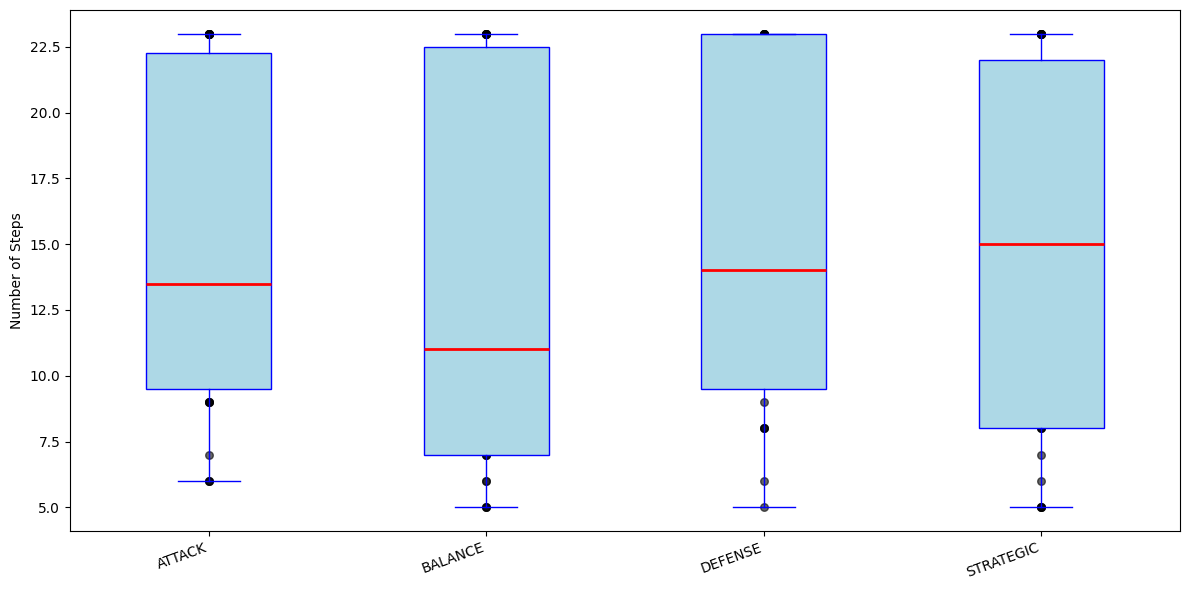

In [15]:
win_steps = collect_win_steps(paths, group_by="persona")   # từ hàm trước đó
plot_win_steps_box_scatter(win_steps)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def collect_move_directions(paths):
    """
    Thống kê số lần agent A chọn A1-A5 theo chiều (clockwise/counter_clockwise)
    Trả về dict { "A1": {"cw": count, "ccw": count}, ... }
    """
    counts = {c: {"cw": 0, "ccw": 0} for c in ["A1","A2","A3","A4","A5"]}

    for path in paths:
        try:
            log = load_json(path)
            player_a = get_model_name(log["setup"]["player_a"]["endpoint"])

            for step in log.get("step_by_step", []):
                action = step.get("action", [])
                if not action:
                    continue

                cell, direction = action
                if cell in counts and "random_agent" not in player_a:  # bỏ random agent
                    if direction == "clockwise":
                        counts[cell]["cw"] += 1
                    elif direction == "counter_clockwise":
                        counts[cell]["ccw"] += 1
        except:
            continue

    return counts

def plot_move_directions(counts, agent_name="Agent A"):
    """
    Vẽ biểu đồ cột 2 chiều đối xứng qua trục X (cw dương, ccw âm)
    Hiển thị số lượng + tỉ lệ (%) trên cột
    """
    cells = list(counts.keys())
    cw_vals = [counts[c]["cw"] for c in cells]
    ccw_vals = [-counts[c]["ccw"] for c in cells]  # âm để vẽ xuống dưới

    x = np.arange(len(cells))
    width = 0.4

    plt.figure(figsize=(8,6))
    plt.bar(x, cw_vals, width, label="Clockwise", color="#4CAF50")
    plt.bar(x, ccw_vals, width, label="Counter-clockwise", color="#F44336")

    # hiển thị số + %
    for i, cell in enumerate(cells):
        total = counts[cell]["cw"] + counts[cell]["ccw"]

        # clockwise
        v_cw = counts[cell]["cw"]
        if v_cw > 0 and total > 0:
            pct = v_cw * 100 / total
            plt.text(i, cw_vals[i] + 0.1, f"{v_cw} ({pct:.1f}%)", 
                     ha='center', va='bottom', fontsize=9)

        # counter-clockwise
        v_ccw = counts[cell]["ccw"]
        if v_ccw > 0 and total > 0:
            pct = v_ccw * 100 / total
            plt.text(i, ccw_vals[i] - 0.1, f"{v_ccw} ({pct:.1f}%)", 
                     ha='center', va='top', fontsize=9)

    plt.axhline(0, color="black", linewidth=0.8)
    plt.xticks(x, cells)
    plt.yticks([])   # ẩn nhãn trục Y
    plt.ylabel("Move Count")
    plt.ylim(-100, 100)
    plt.title(f"{agent_name} PERSONA")
    plt.legend()
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
from glob import glob

PERSONAS = ["ATTACK", "DEFENSE", "BALANCE", "STRATEGIC"]  # fix typo

def collect_move_directions(paths):
    counts = {c: {"cw": 0, "ccw": 0} for c in ["A1","A2","A3","A4","A5"]}
    for path in paths:
        try:
            log = load_json(path)
            player_a = get_model_name(log["setup"]["player_a"]["endpoint"])
            for step in log.get("step_by_step", []):
                action = step.get("action", [])
                if not action:
                    continue
                cell, direction = action
                if cell in counts and "random_agent" not in player_a:
                    if direction == "clockwise":
                        counts[cell]["cw"] += 1
                    elif direction == "counter_clockwise":
                        counts[cell]["ccw"] += 1
        except Exception:
            continue
    return counts



# --- vẽ 4 subplots trên 1 figure ---
def plot_move_directions_grid(report, personas=PERSONAS):
    cells = ["A1","A2","A3","A4","A5"]
    x = np.arange(len(cells))
    width = 0.45

    # cùng trục Y: lấy trị tuyệt đối lớn nhất trong tất cả persona
    ymax = 1
    for p in personas:
        c = report[p]
        ymax = max(ymax,
                   max(c[k]["cw"] for k in cells),
                   max(c[k]["ccw"] for k in cells))
    ylim = (-ymax*1.15, ymax*1.15)

    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, p in zip(axes, personas):
        counts = report[p]
        cw  = np.array([counts[k]["cw"]  for k in cells])
        ccw = -np.array([counts[k]["ccw"] for k in cells])  # vẽ xuống dưới

        ax.bar(x, cw,  width, label="Clockwise")
        ax.bar(x, ccw, width, label="Counter-clockwise")

        # nhãn số + %
        for i, k in enumerate(cells):
            total = counts[k]["cw"] + counts[k]["ccw"]
            if total > 0:
                if counts[k]["cw"] > 0:
                    pct = counts[k]["cw"] * 100 / total
                    ax.text(i, cw[i] + ymax*0.03, f'{counts[k]["cw"]} ({pct:.1f}%)',
                            ha="center", va="bottom", fontsize=8)
                if counts[k]["ccw"] > 0:
                    pct = counts[k]["ccw"] * 100 / total
                    ax.text(i, ccw[i] - ymax*0.03, f'{counts[k]["ccw"]} ({pct:.1f}%)',
                            ha="center", va="top", fontsize=8)

        ax.axhline(0, color="black", linewidth=0.8)
        ax.set_title(p, fontsize=11)
        ax.set_ylim(*ylim)
        ax.set_xticks(x, cells)
        ax.tick_params(axis="y", length=0, labelleft=False)

    # legend gọn: đặt 1 lần cho cả figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=True, fontsize=10) 
    fig.tight_layout()
    plt.show()




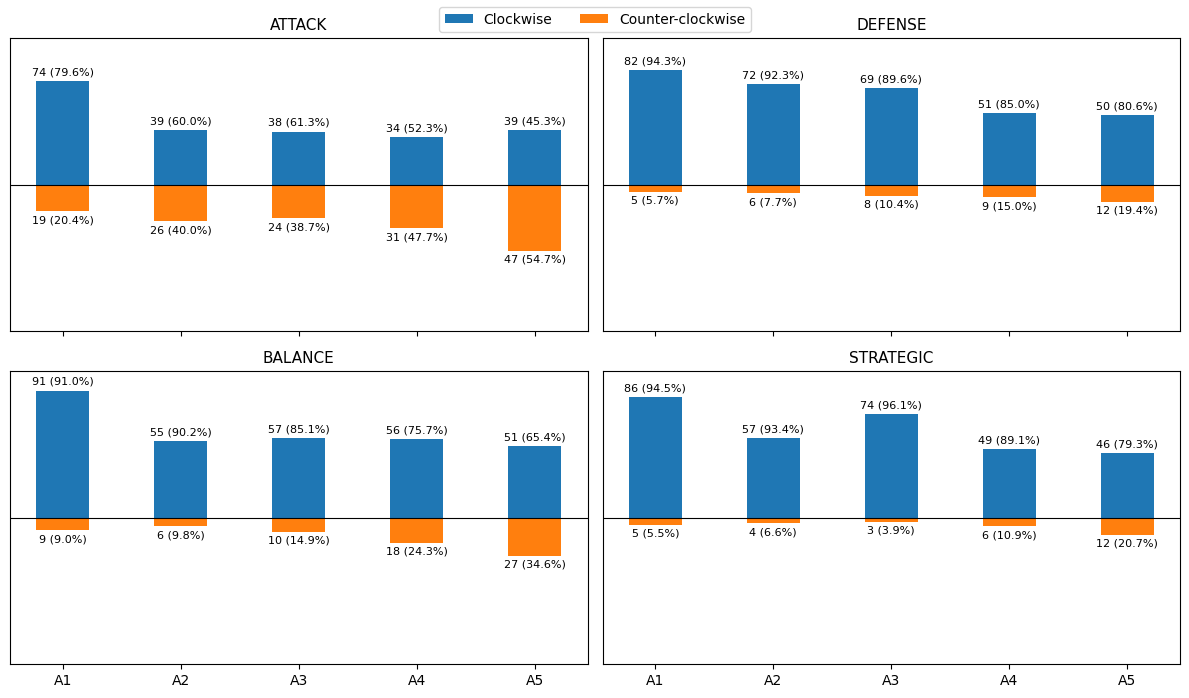

In [17]:
# --- thu thập ---
move_direction_report = {
    "ATTACK":    collect_move_directions(glob("../logs/ex_persona_instruct/ATTACK/*")),
    "DEFENSE":   collect_move_directions(glob("../logs/ex_persona_instruct/DEFENSE/*")),
    "BALANCE":   collect_move_directions(glob("../logs/ex_persona_instruct/BALANCE/*")),
    "STRATEGIC": collect_move_directions(glob("../logs/ex_persona_instruct/STRATEGIC/*")),
}

plot_move_directions_grid(move_direction_report)

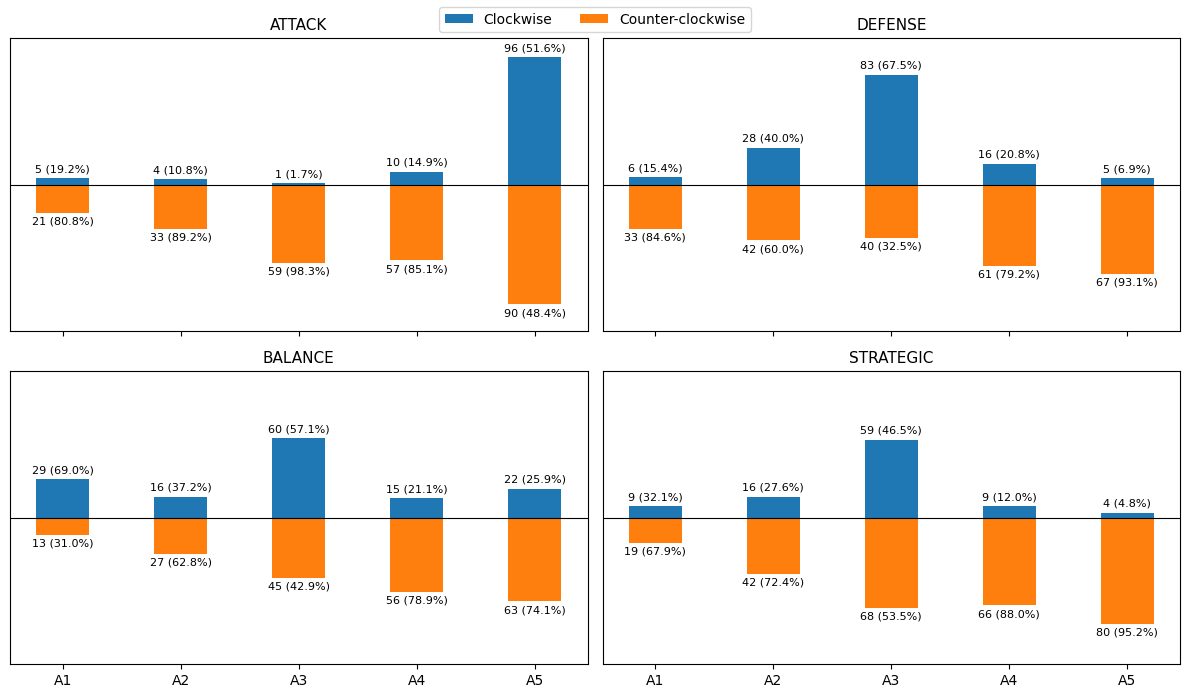

In [18]:
# --- thu thập ---
move_direction_report = {
    "ATTACK":    collect_move_directions(glob("../logs/persona_instruct_deepseek/ex_persona/ATTACK/*")),
    "DEFENSE":   collect_move_directions(glob("../logs/persona_instruct_deepseek/ex_persona/DEFENSE/*")),
    "BALANCE":   collect_move_directions(glob("../logs/persona_instruct_deepseek/ex_persona/BALANCE/*")),
    "STRATEGIC": collect_move_directions(glob("../logs/persona_instruct_deepseek/ex_persona/STRATEGIC/*")),
}

plot_move_directions_grid(move_direction_report)

# Memory


In [19]:
def collect_win_rate(paths, include_random=False, group_by="endpoint"):
    """
    Tính số trận thắng/hòa cho từng agent từ nhiều file JSON
    """
    stats = defaultdict(lambda: {"wins": 0, "draws": 0, "games": 0})

    for path in paths:
        try:
            log = load_json(path)
            player_a_val = log["setup"]["player_a"].get(group_by)
            player_a = get_model_name(str(player_a_val)) if player_a_val else "random_agent"
            player_b = "random_agent"

            winner = log["result"].get("winner", None)

            # tăng tổng số game
            if "random_agent" not in player_a or include_random:
                stats[player_a]["games"] += 1
            if "random_agent" not in player_b or include_random:
                stats[player_b]["games"] += 1

            if not winner or winner == "draw":
                # hòa: cộng cho cả 2 bên
                if "random_agent" not in player_a or include_random:
                    stats[player_a]["draws"] += 1
                if "random_agent" not in player_b or include_random:
                    stats[player_b]["draws"] += 1
            else:
                winner_ep = log["setup"][winner].get(group_by)
                winner_name = get_model_name(str(winner_ep)) if winner_ep else "random_agent"

                if "random_agent" in winner_name and not include_random:
                    continue
                stats[winner_name]["wins"] += 1

        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    # tạo report với win_rate + draw_rate
    report = {}
    for agent, v in stats.items():
        if v["games"] > 0:
            report[agent] = {
                "wins": v["wins"],
                "draws": v["draws"],
                "games": v["games"],
                "win_rate": round(v["wins"] * 100 / v["games"], 2),
                "draw_rate": round(v["draws"] * 100 / v["games"], 2)
            }
    return report


paths = glob("../logs/persona_instruct_deepseek/ex_memory/**/*.json", recursive=True)
report = collect_win_rate(paths, include_random=False, group_by="mem_size")
df = pd.DataFrame(report).T
df

,wins,draws,games,win_rate,draw_rate
1,20.0,1.0,50.0,40.0,2.0
10,29.0,3.0,50.0,58.0,6.0
3,32.0,2.0,50.0,64.0,4.0
5,25.0,3.0,50.0,50.0,6.0


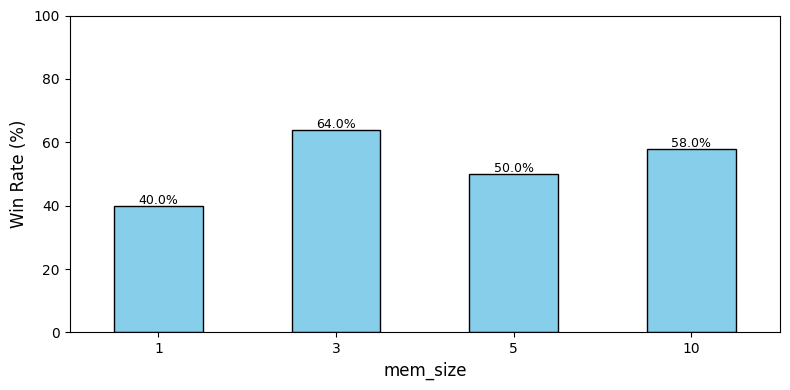

In [20]:
import matplotlib.pyplot as plt

# Ép index về int rồi sort theo thứ tự tăng dần
df_sorted = df.copy()
df_sorted.index = df_sorted.index.astype(int)
df_sorted = df_sorted.sort_index()

ax = df_sorted["win_rate"].plot(
    kind="bar",
    figsize=(8, 4),
    color="skyblue",
    edgecolor="black"
)

plt.xlabel("mem_size", fontsize=12)
plt.ylabel("Win Rate (%)", fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=0)

for i, v in enumerate(df_sorted["win_rate"]):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()




In [21]:
from collections import defaultdict
import numpy as np

def collect_rule_effect(paths, group_by="rules"):
    """
    Gom thống kê theo rule set:
    - avg_steps: số bước trung bình mỗi game
    - ratio_mandarin_per_step: tỉ lệ ăn quan trên mỗi bước
    - ratio_peasant_per_step: tỉ lệ ăn dân trên mỗi bước
    """
    stats = defaultdict(lambda: {
        "games": 0,
        "steps": [],
        "captured_mandarin": 0,
        "captured_peasant": 0,
        "total_steps": 0
    })

    for path in paths:
        try:
            log = load_json(path)

            # gom theo rule-set (tuple làm key)
            rule_set = "+".join(log["enviroment"]["special_rules"])

            steps = len(log.get("step_by_step", []))
            mandarin = sum(step.get("captured_mandarin", 0) for step in log.get("step_by_step", []))
            peasant = sum(step.get("captured_peasant", 0) for step in log.get("step_by_step", []))

            stats[rule_set]["games"] += 1
            stats[rule_set]["steps"].append(steps)
            stats[rule_set]["captured_mandarin"] += mandarin
            stats[rule_set]["captured_peasant"] += peasant
            stats[rule_set]["total_steps"] += steps

        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    # tạo report
    report = {}
    for rule_set, v in stats.items():
        if v["games"] > 0:
            report[rule_set] = {
                "games": v["games"],
                "avg_steps": round(np.mean(v["steps"]), 2),
                "captured_mandarin": v["captured_mandarin"] / v["steps"],
                "captured_peasant": v["captured_peasant"] / v["steps"],
                "ratio_mandarin_per_turn": round(v["captured_mandarin"] / v["total_steps"], 3) if v["total_steps"] > 0 else 0,
                "ratio_peasant_per_turn": round(v["captured_peasant"] / v["total_steps"], 3) if v["total_steps"] > 0 else 0,
            }
    return report


paths = glob("../logs/ex_rule/**/*.json", recursive=True)
report = collect_rule_effect(paths, group_by="special_rules")
df = pd.DataFrame(report).T
df

TypeError: unsupported operand type(s) for /: 'int' and 'list'

# Hàm đánh giá hiệu suất

In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
import random

# ----------------- cấu hình thang điểm & trọng số (tuỳ chỉnh nếu cần) -----------------
S_MAX  = 30
M_MAX  = 2
P_MAX  = 50
ALPHA, BETA, GAMMA, DELTA, EPSILON = 0.5, 0.2, 0.1, 0.1, 0.1

def evaluate_agent(W, D, S, M, P, 
                   total_games=50, S_max=S_MAX, 
                   M_max=M_MAX, P_max=P_MAX,
                   alpha=ALPHA, beta=BETA, gamma=GAMMA, delta=DELTA, epsilon=EPSILON):
    win_rate = W / total_games if total_games > 0 else 0
    draw_rate = D / total_games if total_games > 0 else 0
    score_norm    = S / S_max if S_max > 0 else 0
    mandarin_norm = M / M_max if M_max > 0 else 0
    peasant_norm  = P / P_max if P_max > 0 else 0
    perf = (alpha * win_rate
            + beta * draw_rate
            + gamma * score_norm
            + delta * mandarin_norm
            + epsilon * peasant_norm)
    return round(perf, 4)

# ----------------- helpers -----------------
def safe_get(obj, key):
    """Lấy obj[key] khi obj là dict hoặc list[dict]."""
    if isinstance(obj, dict):
        return obj.get(key)
    if isinstance(obj, list) and obj and isinstance(obj[0], dict):
        return obj[0].get(key)
    return None

def get_agent_side_and_name(log, group_by="endpoint"):
    """
    Xác định agent chính (không phải random_agent) và side tương ứng ('player_a' hoặc 'player_b').
    """
    pa_val = safe_get(log["setup"].get("player_a", {}), group_by)
    pb_val = safe_get(log["setup"].get("player_b", {}), group_by)
    pa_name = get_model_name(str(pa_val)) if pa_val else "random_agent"
    pb_name = get_model_name(str(pb_val)) if pb_val else "random_agent"

    if "random_agent" not in pa_name.lower():
        return "player_a", pa_name
    else:
        return "player_b", pb_name

def get_agent_score_from_winner_first(log, agent_side):
    """
    Format:
      result.winner = 'player_a'/'player_b'/None
      result.score  = [score_winner, score_loser]
    Trả về điểm của agent theo side cung cấp.
    """
    res   = log.get("result", {})
    winner = res.get("winner", None)
    score  = res.get("score", None)

    if not (isinstance(score, list) and len(score) == 2):
        return 0

    if winner in ("player_a", "player_b"):
        return score[0] if agent_side == winner else score[1]
    else:
        # hòa/không xác định: dùng trung bình
        return (score[0] + score[1]) / 2

# ----------------- hàm chính: gom & xuất DataFrame, kèm baseline Random Agent -----------------
def collect_agent_performance(paths, group_by="endpoint", include_random_baseline=True, random_games=50):
    """
    Trả về dict {agent: metrics} kèm baseline 'Random Agent' (50 trận ngẫu nhiên mặc định).
    Metrics:
      win_rate, draw_rate, avg_score, avg_mandarin, avg_peasant, performance_score
    Lưu ý: avg_mandarin/avg_peasant tính theo tổng captured của cả trận (không phân biệt actor).
    """
    stats = defaultdict(lambda: {
        "wins": 0, "draws": 0, "games": 0,
        "scores": [], "mandarins": [], "peasants": []
    })
    random_logs = []  # gom tất cả trận có random agent để làm baseline

    for path in paths:
        try:
            log = load_json(path)

            # kiểm tra random có tham gia không để gom cho baseline
            pa_ep = safe_get(log["setup"].get("player_a", {}), group_by)
            pb_ep = safe_get(log["setup"].get("player_b", {}), group_by)
            pa_name_raw = get_model_name(str(pa_ep)) if pa_ep else "random_agent"
            pb_name_raw = get_model_name(str(pb_ep)) if pb_ep else "random_agent"
            has_random = ("random_agent" in str(pa_name_raw).lower()) or ("random_agent" in str(pb_name_raw).lower())
            if include_random_baseline and has_random:
                random_logs.append(log)

            # 1) xác định agent chính (bên không phải random_agent) và side
            agent_side, agent_name = get_agent_side_and_name(log, group_by=group_by)

            # 2) games / wins / draws
            winner = log.get("result", {}).get("winner", None)
            if not winner or winner == "draw":
                stats[agent_name]["draws"] += 1
            else:
                if winner == agent_side:
                    stats[agent_name]["wins"] += 1
            stats[agent_name]["games"] += 1

            # 3) điểm cuối trận theo winner-first
            agent_score = get_agent_score_from_winner_first(log, agent_side)
            stats[agent_name]["scores"].append(agent_score)

            # 4) tổng quan & dân của cả trận
            steps = log.get("step_by_step", [])
            mandarin_total = sum(s.get("captured_mandarin", 0) for s in steps)
            peasant_total  = sum(s.get("captured_peasant", 0)  for s in steps)
            stats[agent_name]["mandarins"].append(mandarin_total)
            stats[agent_name]["peasants"].append(peasant_total)

        except Exception as e:
            print(f"Skip {path} vì lỗi: {e}")
            continue

    # ---- xử lý baseline Random Agent từ mẫu ngẫu nhiên ----
    if include_random_baseline and random_logs:
        sampled = random.sample(random_logs, min(random_games, len(random_logs)))
        RA = "Random Agent"
        for log in sampled:
            # xác định side của random trong game này
            pa_ep = safe_get(log["setup"].get("player_a", {}), group_by)
            pb_ep = safe_get(log["setup"].get("player_b", {}), group_by)
            pa_name_raw = get_model_name(str(pa_ep)) if pa_ep else "random_agent"
            pb_name_raw = get_model_name(str(pb_ep)) if pb_ep else "random_agent"

            if "random_agent" in str(pa_name_raw).lower():
                ra_side = "player_a"
            elif "random_agent" in str(pb_name_raw).lower():
                ra_side = "player_b"
            else:
                # không tìm thấy random, bỏ qua
                continue

            # games / wins / draws cho Random Agent
            winner = log.get("result", {}).get("winner", None)
            if not winner or winner == "draw":
                stats[RA]["draws"] += 1
            else:
                if winner == ra_side:
                    stats[RA]["wins"] += 1
            stats[RA]["games"] += 1

            # điểm cho Random theo winner-first
            ra_score = get_agent_score_from_winner_first(log, ra_side)
            stats[RA]["scores"].append(ra_score)

            # tổng captured cả trận
            steps = log.get("step_by_step", [])
            mandarin_total = sum(s.get("captured_mandarin", 0) for s in steps)
            peasant_total  = sum(s.get("captured_peasant", 0)  for s in steps)
            stats[RA]["mandarins"].append(mandarin_total)
            stats[RA]["peasants"].append(peasant_total)

    # ---- kết sổ -> report ----
    report = {}
    for agent, v in stats.items():
        G = v["games"]
        if G == 0:
            continue
        W, D = v["wins"], v["draws"]
        S = float(np.mean(v["scores"]))    if v["scores"]    else 0.0
        M = float(np.mean(v["mandarins"])) if v["mandarins"] else 0.0
        P = float(np.mean(v["peasants"]))  if v["peasants"]  else 0.0

        report[agent] = {
            "win_rate":   round(W * 100 / G, 2),
            "draw_rate":  round(D * 100 / G, 2),
            "avg_score":    round(S, 2),
            "avg_mandarin": round(M, 2),
            "avg_peasant":  round(P, 2),
            "performance_score": evaluate_agent(W, D, S, M, P, total_games=G)
        }
    return report

# ----------------- ví dụ chạy & xuất DataFrame -----------------
paths = glob("../logs/ex_backbone/**/*.json", recursive=True)
report = collect_agent_performance(paths, group_by="endpoint",
                                   include_random_baseline=True, random_games=50)
df = pd.DataFrame(report).T.sort_values("performance_score", ascending=False)
df.sort_index()

Skip ../logs/ex_backbone\llama4\report.2025.09.18.210612.json vì lỗi: 'NoneType' object has no attribute 'get'
Skip ../logs/ex_backbone\llama4\report.2025.09.18.210633.json vì lỗi: 'NoneType' object has no attribute 'get'
Skip ../logs/ex_backbone\llama_3.1_8b\report.2025.09.16.223419.json vì lỗi: 'NoneType' object has no attribute 'get'


,win_rate,draw_rate,avg_score,avg_mandarin,avg_peasant,performance_score
DeepSeek-R1-Distill-Llama-70B,64.00,4.00,23.84,0.74,40.52,0.5255
Gemini-2.0-flash,50.00,4.00,24.86,1.04,40.48,0.4738
Gemini-2.0-flash-lite,52.17,4.35,24.96,0.91,42.96,0.4843
Llama-3.1-8B-Instruct,38.78,4.08,22.00,0.69,40.80,0.3917
Llama-3.3-70B-Instruct,42.00,0.00,22.92,0.74,40.88,0.4052
Llama-4-Maverick-17B-128E,44.44,2.78,23.08,1.00,37.31,0.4293
Random Agent,48.00,6.00,23.38,0.76,40.60,0.4491
lgai/exaone-3-5-32b-instruct,40.00,8.00,23.12,0.60,42.10,0.4073


In [ ]:
paths = glob("../logs/persona_instruct_deepseek/ex_persona/**/*.json", recursive=True)
report = collect_agent_performance(paths, group_by="persona",
                                   include_random_baseline=False, random_games=50)
df = pd.DataFrame(report).T
df = df.sort_index(ascending=True)
df

,win_rate,draw_rate,avg_score,avg_mandarin,avg_peasant,performance_score
ATTACK,60.0,4.0,23.40,0.76,39.98,0.5040
BALANCE,54.0,4.0,24.38,0.82,41.22,0.4827
DEFENSE,46.0,8.0,23.30,0.72,41.60,0.4429
STRATEGIC,54.0,6.0,23.90,0.78,41.96,0.4846


In [ ]:
paths = glob("../logs/ex_persona_instruct/**/*.json", recursive=True)
report = collect_agent_performance(paths, group_by="persona",
                                   include_random_baseline=False, random_games=50)
df = pd.DataFrame(report).T
df = df.sort_index(ascending=True)
df

Skip ../logs/ex_persona_instruct\BALANCE\report.2025.09.15.161909.json vì lỗi: 'NoneType' object has no attribute 'get'


,win_rate,draw_rate,avg_score,avg_mandarin,avg_peasant,performance_score
ATTACK,50.00,4.00,23.06,0.84,39.46,0.4558
BALANCE,53.06,8.16,23.71,0.76,40.65,0.4797
DEFENSE,48.00,4.00,23.38,0.82,39.26,0.4455
STRATEGIC,58.00,4.00,24.48,0.92,39.26,0.5041


In [ ]:
paths = glob("../logs/persona_instruct_deepseek/ex_memory/**/*.json", recursive=True)
report = collect_agent_performance(paths, group_by="mem_size",
                                   include_random_baseline=False, random_games=50)
df = pd.DataFrame(report).T
df.index = pd.to_numeric(df.index)   # ép index về số
df = df.sort_index(ascending=True)
deepseek70b = df["performance_score"].to_list()
df

,win_rate,draw_rate,avg_score,avg_mandarin,avg_peasant,performance_score
1,40.0,2.0,22.72,0.64,42.02,0.3958
3,64.0,4.0,25.14,0.74,41.74,0.5323
5,50.0,6.0,22.70,0.76,41.64,0.4589
10,58.0,6.0,25.18,0.84,40.74,0.5094


In [ ]:
paths = glob("../logs/ex_memory/**/*.json", recursive=True)
report = collect_agent_performance(paths, group_by="mem_size",
                                   include_random_baseline=False, random_games=50)
df = pd.DataFrame(report).T
df.index = pd.to_numeric(df.index)   # ép index về số
df = df.sort_index(ascending=True)
llama70b = df["performance_score"].to_list()
df

,win_rate,draw_rate,avg_score,avg_mandarin,avg_peasant,performance_score
1,48.0,6.0,23.28,0.72,39.90,0.4454
3,46.0,4.0,23.14,0.74,39.46,0.4311
5,46.0,2.0,22.80,0.90,38.78,0.4326
10,52.0,4.0,23.00,0.72,38.74,0.4581


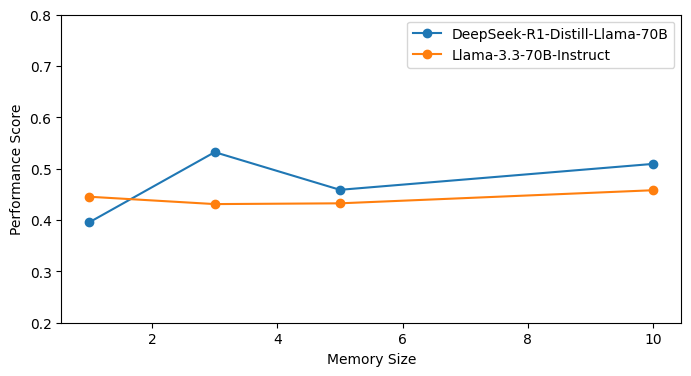

In [ ]:
INDEX = df.index.to_list()
plt.figure(figsize=(8,4))
plt.plot(INDEX, deepseek70b, marker='o', label='DeepSeek-R1-Distill-Llama-70B')
plt.plot(INDEX, llama70b, marker='o', label='Llama-3.3-70B-Instruct')
plt.ylim(0.2, 0.8)
plt.xlabel("Memory Size")
plt.ylabel("Performance Score")
plt.legend()